In [1]:
import numpy as np
import matplotlib.pyplot as plt
import translation
import elongation.utils
from Bio import SeqIO
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
genes_string = {}
genes_sequence = {}
for record in SeqIO.parse("genes.fasta", "fasta"):
    gene_seq = str(record.seq)
    genes_sequence[record.id] = gene_seq
    genes_string[record.id] = [gene_seq[n*3:(n+1)*3] for n in range(int(len(gene_seq)/3))]

In [3]:
indexes = {}
for gene in genes_string.keys():
    inds = []
    xx = genes_string[gene]
    for i, codon in enumerate(xx):
        if codon in ['CCA', 'CCC', 'CCG', 'AAT']:
            inds.append(i)
    indexes[gene] = inds

In [13]:
def simulate(gene, slow_proline=False):
    sim = translation.translation()
    sim.loadConcentrations("/mnt/Projects/RSim/data/concentrations.csv")
    sim.loadMRNA("genes.fasta", gene)
    sim.setInitiationRate(100)
    sim.setTerminationRate(100)
    if slow_proline:
        print(slow_proline)
        props = sim.getPropensities()
        for i, index in enumerate(indexes[gene]):
            if (indexes[gene][i-1]+1 == index):
                #consecutive proline
                props[index]["dec7f"] /= 6
            else:
                props[index]["dec7f"] /= 4.5
        sim.setPropensities(props)
    sim.setFinishedRibosomes(1000)
    sim.setHistorySize(10000000)
    sim.run()
    sim.calculateAverageTimes()
    return (gene, (sim.getEnlogationDuration()[0], sim.dt_history, sim.ribosome_positions_history, sim.average_times))

In [ ]:
sim_results = {}
for gene in tqdm(genes_string.keys()):
    sim_results[gene] = simulate(gene, slow_proline=False) 
sim_results_normal_proline = sim_results

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
elongating_times_slow_proline = {}
for gene in tqdm(genes_string.keys()):
    elongating_times_slow_proline[gene] = simulate(gene, slow_proline=True) 

In [14]:
sim_results = Parallel(n_jobs=-1)(delayed(simulate)(gene, slow_proline=False) for gene in tqdm(genes_string.keys()))
elongating_times = {key: values for key, *values in sim_results}

100%|██████████| 15/15 [00:00<00:00, 152.71it/s]


In [15]:
sim_results = Parallel(n_jobs=-1)(delayed(simulate)(gene, slow_proline=True) for gene in tqdm(genes_string.keys()))
elongating_times_slow_proline = {key: values for key, *values in sim_results}

100%|██████████| 15/15 [00:00<00:00, 9159.20it/s]


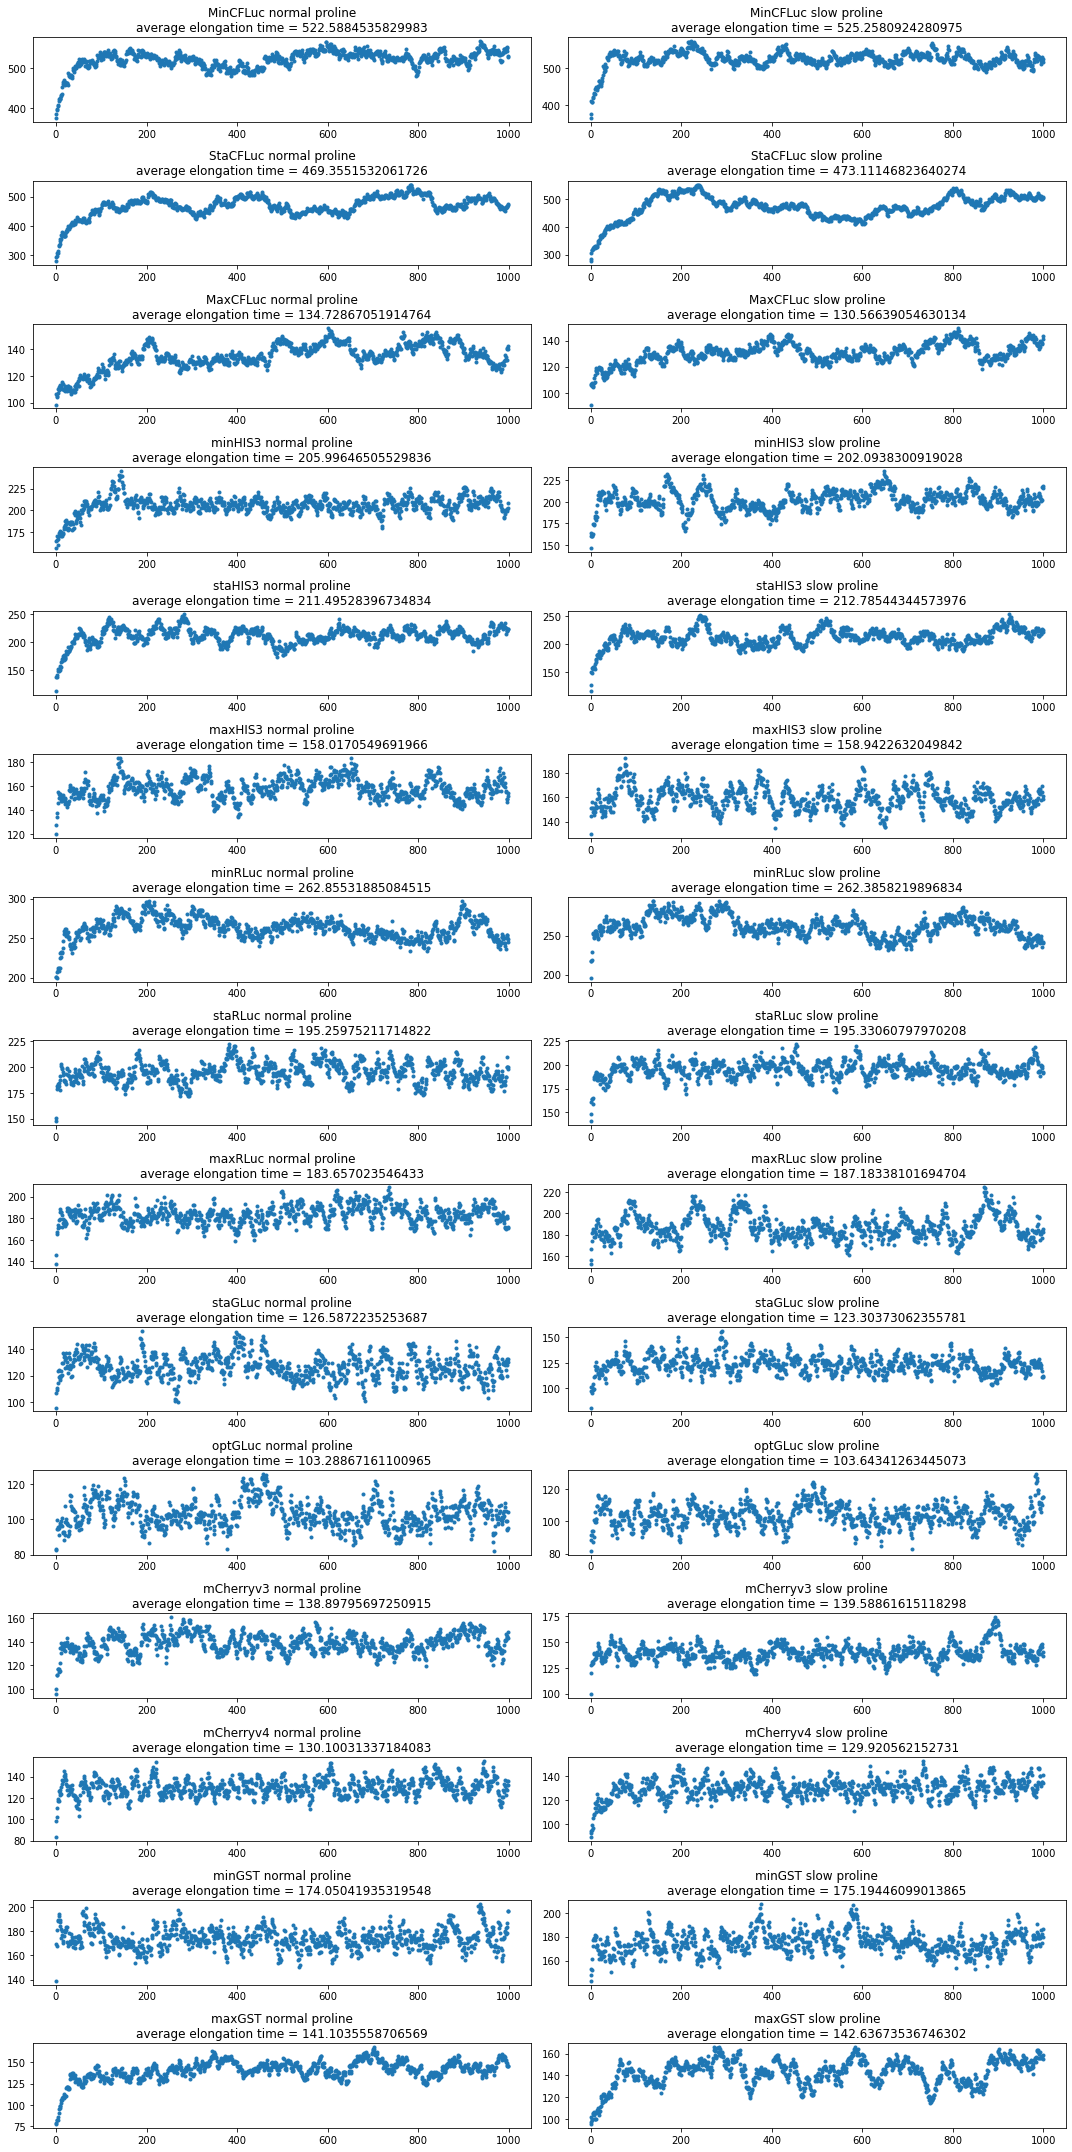

In [43]:
f, ax = plt.subplots(len(elongating_times.keys()), 2, figsize=(15,30))
i = 0
for gene in elongating_times.keys():
    ax[i, 0].plot(elongating_times[gene][0][0], '.')
    ax[i, 0].set_title(gene +' normal proline\naverage elongation time = ' + str(np.mean(elongating_times[gene][0][0])))
    ax[i, 1].plot(elongating_times_slow_proline[gene][0][0], '.')
    ax[i, 1].set_title(gene +' slow proline\naverage elongation time = ' + str(np.mean(elongating_times_slow_proline[gene][0][0])))
    i +=1
plt.tight_layout()

In [21]:
slow_proline = True
sim = translation.translation()
sim.loadConcentrations("/mnt/Projects/RSim/data/concentrations.csv")
sim.inputMRNA(genes_sequence[gene])
sim.setInitiationRate(100)
sim.setTerminationRate(100)
if slow_proline:
    props = sim.getPropensities()
    for index in indexes[gene]:
        props[index]["dec7f"] /= 4.5
    sim.setPropensities(props)
sim.setFinishedRibosomes(100)
sim.setHistorySize(10000000)
sim.run()
sim.calculateAverageTimes()

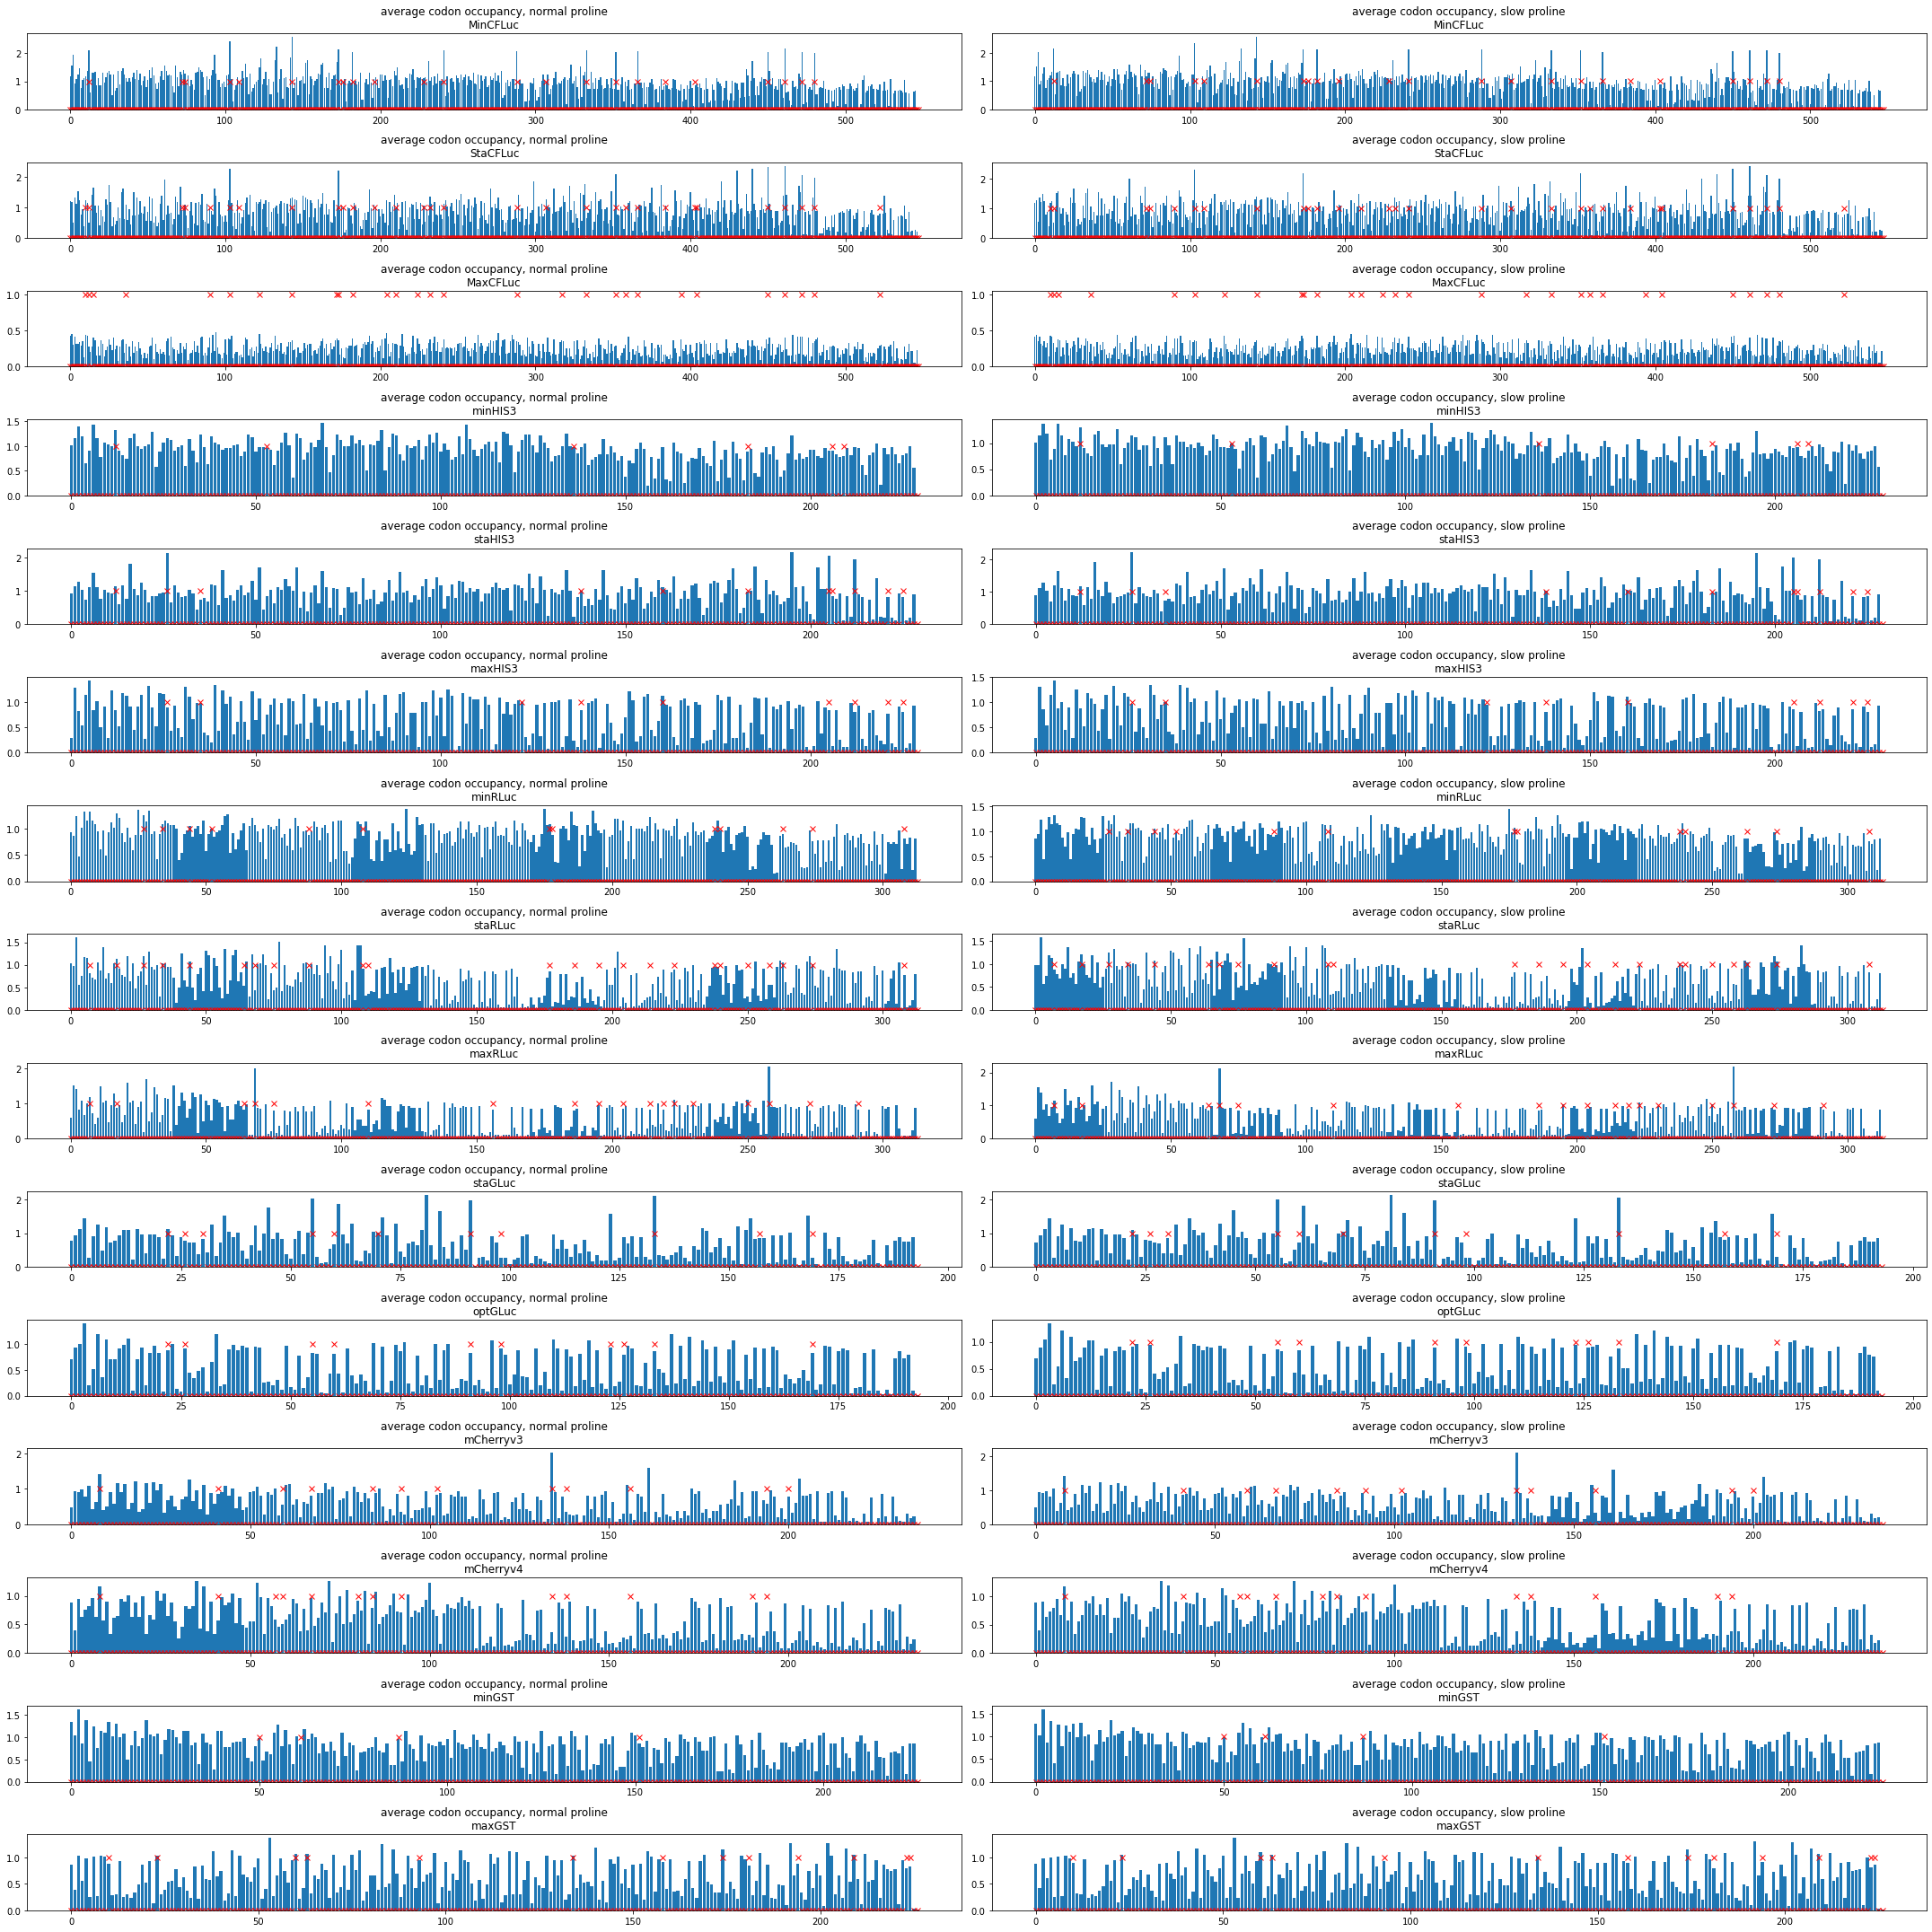

In [42]:
f, ax = plt.subplots(len(elongating_times.keys()), 2, figsize=(30,30))
i = 0
for gene in elongating_times.keys():
    ax[i, 0].bar(range(len(elongating_times[gene][0][3])), elongating_times[gene][0][3])
    xx = np.zeros(len(elongating_times[gene][0][3]))
    xx[indexes[gene]] = 1
    ax[i, 0].plot(xx, 'xr' )
    ax[i, 0].set_title('average codon occupancy, normal proline\n' + gene)
    
    ax[i, 1].bar(range(len(elongating_times_slow_proline[gene][0][3])), elongating_times_slow_proline[gene][0][3])
    xx = np.zeros(len(elongating_times_slow_proline[gene][0][3]))
    xx[indexes[gene]] = 1
    ax[i, 1].plot(xx, 'xr' )
    ax[i, 1].set_title('average codon occupancy, slow proline\n' + gene)
    i +=1
plt.tight_layout()




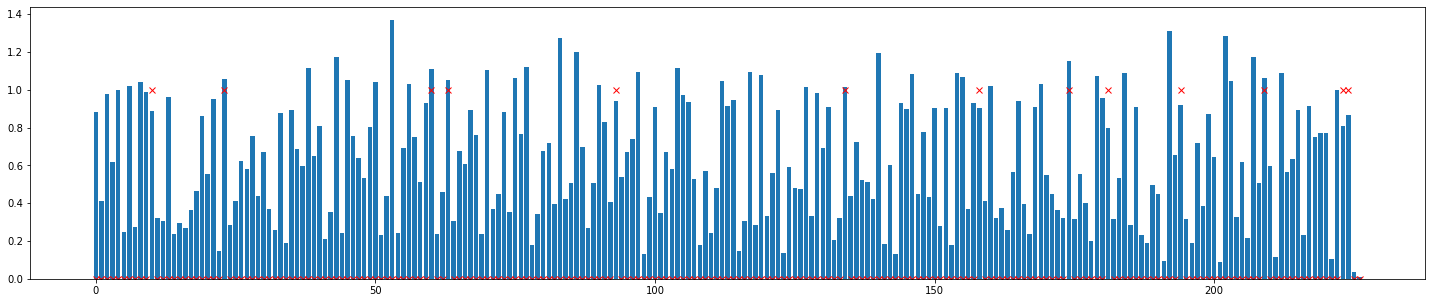

In [38]:
plt.figure(figsize=(25,5))
plt.bar(range(len(elongating_times_slow_proline[gene][0][3])), elongating_times_slow_proline[gene][0][3])
xx = np.zeros(len(elongating_times[gene][0][3]))
xx[indexes[gene]] = 1
plt.plot(xx, 'xr' )

In [ ]:
sim = translation.translation()
sim.inputMRNA